In [33]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO

# Read the JSON file containing the Session Directory
with open(r'C:\Users\arpan\OneDrive\Documents\PoseEstimation\upperbody\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)

# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.columns

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe.csv')
df_mpipe 

# Creating a presentation to save the graphs in
prs=Presentation()

df_mpipe['epoch_time']=df_mpipe['epoch_time']+0.8

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

In [34]:
def pvt(x,t,ylabel='Angle (degrees)'):
    from scipy.signal import savgol_filter
    y=[]
    for i in x:
        y.append(i)
    w = savgol_filter(y,  20,3)
    plt.plot(t,w)
    plt.ylabel(ylabel)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(1)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.5), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

In [35]:
# Finding the calibration frame
f = False
for ind, val in enumerate(df_mpipe['epoch_time'].tolist()):
    for i, v in enumerate(df_mocap['epoch_time'].tolist()):
        if v == val:
            print(ind, i, val)
            mpipe_cf = ind
            mocap_cf = i
            f = True
            break
    if f:
        break

# If no matching calibration frame is found, set default calibration frames
if not f:
    mpipe_cf = 20
    mocap_cf = 20

print('\n-----------------------\n')

# Printing additional matches if available
matches=[]
for ind, val in enumerate(df_mpipe['epoch_time'].tolist()):
    for i, v in enumerate(df_mocap['epoch_time'].tolist()):
        if v == val:
            # print(ind, i, val)
            matches.append((ind, i, val))


7 445 1688376825.389

-----------------------



In [36]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []

# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

# Calculate left elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LS_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LS_y'][i], df_mpipe['LW_z'][i]]))

# Calculate left elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

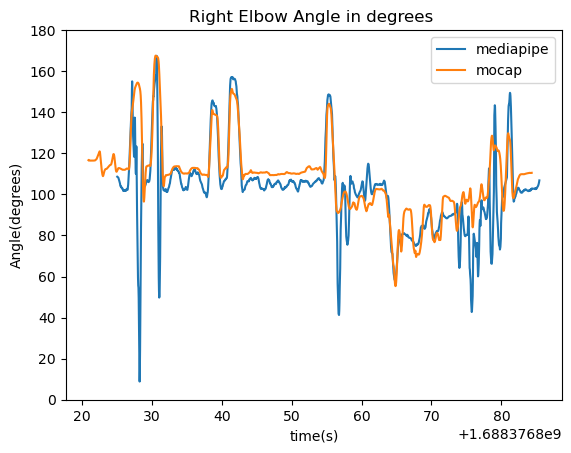

RMSE of Left Elbow Angle:62.048757571169546


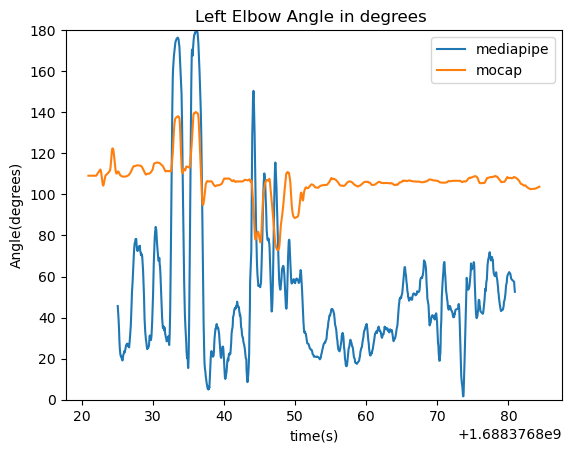

<Figure size 640x480 with 0 Axes>

In [37]:
# graph right elbow angle 
pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'])
pvt(mocapRightElbowAngle,df_mocap['epoch_time'])
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
RMSE_str='RMSE of Right Elbow Angle:'+str(RMSE(mocapRightElbowAngle,mpipeRightElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.show()

# Clear the figure for the next graph
plt.clf()

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'])
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'])
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
RMSE_str='RMSE of Left Elbow Angle:'+str(RMSE(mocapLeftElbowAngle,mpipeLeftElbowAngle,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [38]:
df_mocap.rename(columns={'ls_x':'LS_x','ls_y':'LS_y','ls_z':'LS_z','le_x':'LE_x','le_y':'LE_y','le_z':'LE_z','lw_x':'LW_x','lw_y':'LW_y','lw_z':'LW_z',
                         'rs_x':'RS_x','rs_y':'RS_y','rs_z':'RS_z','re_x':'RE_x','re_y':'RE_y','re_z':'RE_z','rw_x':'RW_x','rw_y':'RW_y','rw_z':'RW_z',
                         'tr_x':'TR_x','tr_y':'TR_y','tr_z':'TR_z'},inplace=True)
df_mpipe.rename(columns={'ls_x':'LS_x','ls_y':'LS_y','ls_z':'LS_z','le_x':'LE_x','le_y':'LE_y','le_z':'LE_z','lw_x':'LW_x','lw_y':'LW_y','lw_z':'LW_z',
                         'rs_x':'RS_x','rs_y':'RS_y','rs_z':'RS_z','re_x':'RE_x','re_y':'RE_y','re_z':'RE_z','rw_x':'RW_x','rw_y':'RW_y','rw_z':'RW_z',
                         'tr_x':'TR_x','tr_y':'TR_y','tr_z':'TR_z'},inplace=True)

In [39]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    S,E,W=np.array(S),np.array(E),np.array(W)
    upperarm=E-S
    lowerarm=W-E

    y=upperarm
    x=-np.cross(upperarm,lowerarm)
    z=np.cross(x,y)
    return np.array([x,y,z]).T

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """

    LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)

    v1=LS-RS
    v2=TR-RS

    basis=gram_schmidt([v1,v2])
    try:
        v1,v2=basis[0],basis[1]
    except:
        return np.nan
    v3=np.cross(v1,v2)

    return np.array([v1,v2,v3]).T

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (w > 1e-10).any():
            basis.append(w/np.linalg.norm(w))
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    R = np.dot(frame2, np.linalg.inv(frame1))
    return R


In [40]:
# callibrating shoulders and trunk

RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [41]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(mpipe_rotated_RS_Cframe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(mpipe_rotated_LS_Cframe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    mpipeRSIE.append(RSeuler[2])
    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    mpipeLSIE.append(LSeuler[2])
    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(mocap_rotated_RS_Cframe,mocapRSF)
    mocapLS_rotmat=rotation_matrix(mocap_rotated_LS_Cframe,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    mocapRSIE.append(RSeuler[2])

    mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    mocapLSIE.append(LSeuler[2])
    
    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

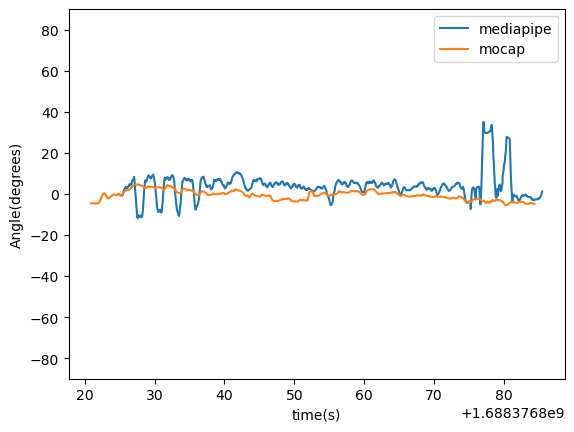

RMSE of forward/backward: 7.257635059601431
RMSE of forward/backward: 3.6355387109187443


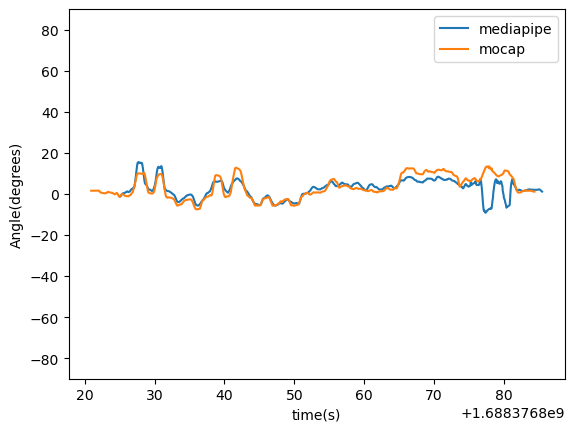

RMSE of forward/backward: 2.8366105663365424


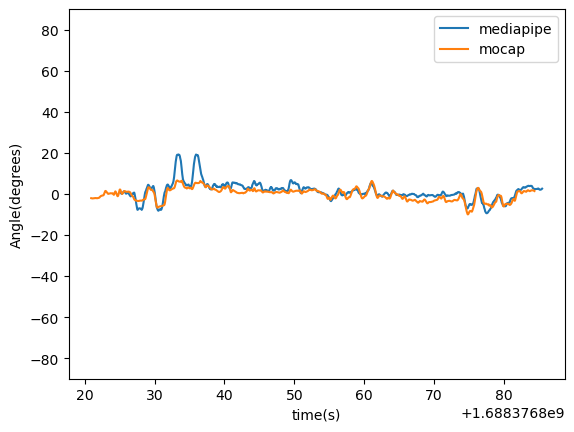

<Figure size 640x480 with 0 Axes>

In [42]:
# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'])
pvt(mocapTRFB,df_mocap['epoch_time'])
plt.ylim(-90,90)
# graph_pth=pth+'\\graph.png'
# plt.savefig(graph_pth)
plt.show()
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapTRFB,mpipeTRFB,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)
# save_graph_to_pptx(prs,pth,graph_pth,RMSE_str)


pvt(mpipeTRLR,df_mpipe['epoch_time'])
pvt(mocapTRLR,df_mocap['epoch_time'])
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapTRLR,mpipeTRLR,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeTRRO,df_mpipe['epoch_time'].tolist())
pvt(mocapTRRO,df_mocap['epoch_time'].tolist())
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapTRRO,mpipeTRRO,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

RMSE of forward/backward: 7.868846704215317


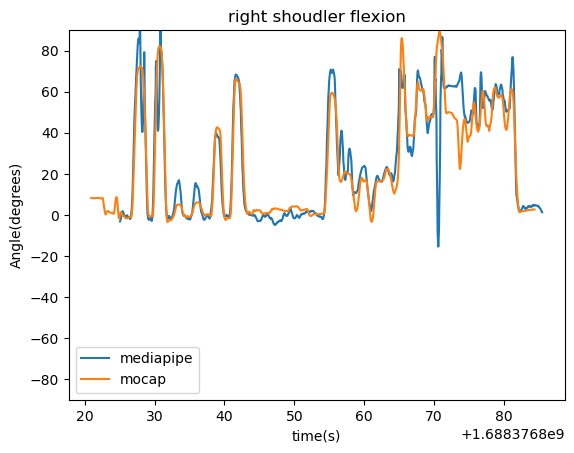

RMSE of forward/backward: 8.334668867104138


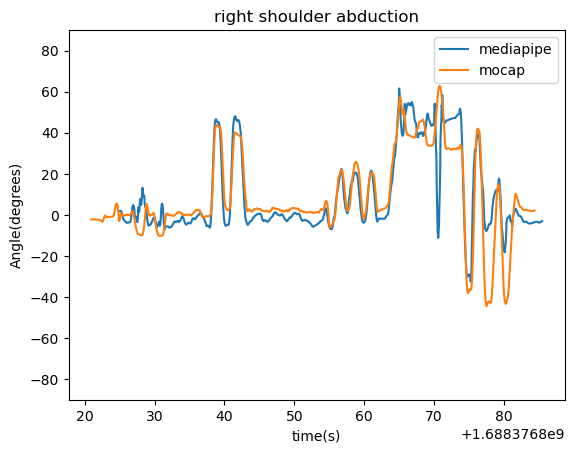

RMSE of forward/backward: 10.431247016152586


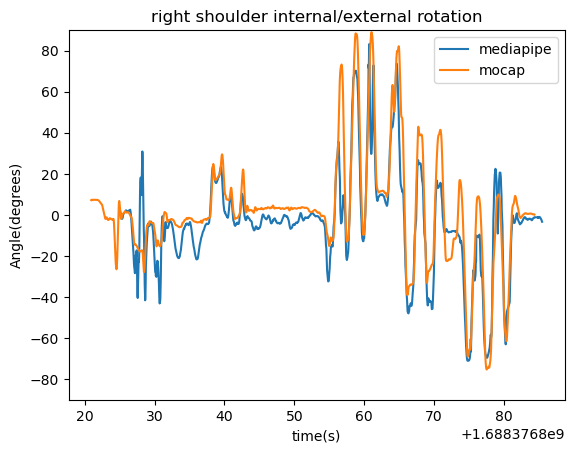

RMSE of forward/backward: 8.580738589362998


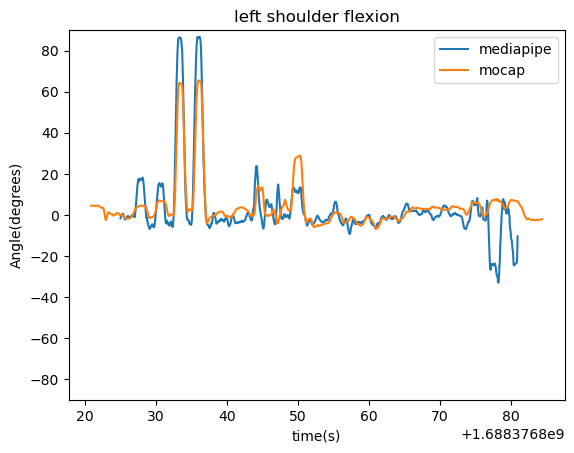

RMSE of forward/backward: 4.908784946091133


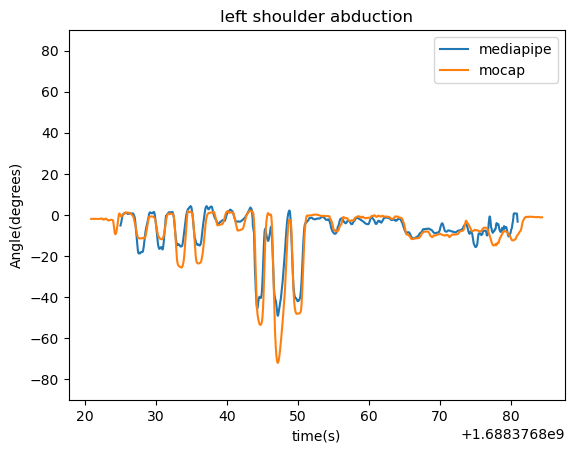

RMSE of forward/backward: 19.732057042764307


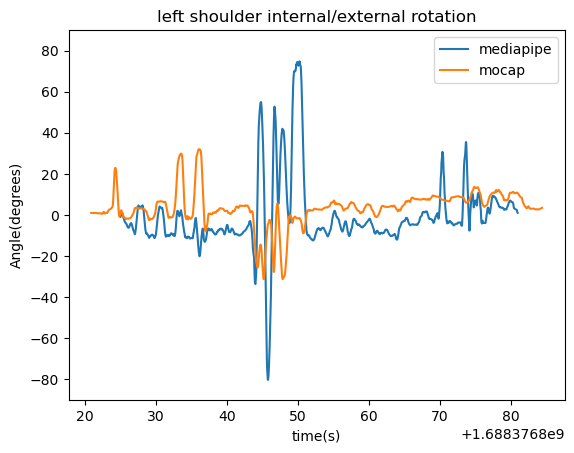

<Figure size 640x480 with 0 Axes>

In [43]:
# Plotting the shoulder angles
pvt(mpipeRSFE,df_mpipe['epoch_time'])
pvt(mocapRSFE,df_mocap['epoch_time'])
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapRSFE,mpipeRSFE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeRSAA,df_mpipe['epoch_time'])
pvt(mocapRSAA,df_mocap['epoch_time'])
plt.title('right shoulder abduction')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapRSAA,mpipeRSAA,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeRSIE,df_mpipe['epoch_time'].tolist())
pvt(mocapRSIE,df_mocap['epoch_time'].tolist())
plt.title('right shoulder internal/external rotation')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapRSIE,mpipeRSIE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeLSFE,df_mpipe['epoch_time'])
pvt(mocapLSFE,df_mocap['epoch_time'])
plt.title('left shoulder flexion')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapLSFE,mpipeLSFE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeLSAA,df_mpipe['epoch_time'])
pvt(mocapLSAA,df_mocap['epoch_time'])
plt.title('left shoulder abduction')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapLSAA,mpipeLSAA,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeLSIE,df_mpipe['epoch_time'].tolist())
pvt(mocapLSIE,df_mocap['epoch_time'].tolist())
plt.title('left shoulder internal/external rotation')
plt.ylim(-90,90)
RMSE_str='RMSE of forward/backward: '+str(RMSE(mocapLSIE,mpipeLSIE,df_mocap['epoch_time'].to_numpy(),df_mpipe['epoch_time'].to_numpy()))
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [44]:
# Save the graphs to the PowerPoint presentation
for graph,error in zip(graphs,RMSEs):
    save_graph_to_pptx(prs, graph, error)

# Save the presentation
prs.save(pth+'\\graphs.pptx')